# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import operator

# Import training and test data

In [2]:
train_data = pd.read_csv('movement_data/fingerprinting_data/train.csv')
test_data = pd.read_csv('movement_data/fingerprinting_data/test.csv')

# Prepare data for model training and validation

In [3]:
def normalise_impute_input(input_features):
    """
    This function normalises the RSSI values into values that fall between 0 and 1.
    Any missing values will be given the maximum value of 1.
    """
    input_features = np.abs(input_features)  # ensure that all rssi values are positive
    num_features = len(input_features[0,:])
    max_value = np.zeros(num_features)
    min_value = np.zeros(num_features)

    for i in range(num_features):
        min_value[i] = np.nanmin(input_features[:,i])
        max_value[i] = np.nanmax(input_features[:,i])
        input_features[:,i] = (input_features[:,i] - min_value[i]) / (max_value[i] - min_value[i] + 1e-6)
    
    input_features[np.isnan(input_features)] = 1.0
        
    return input_features

In [4]:
def prepare_data(data):
    """
    This function splits the data into input features and labels and returns them as outputs.
    """
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle the data
    
    X = data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].values
    X = normalise_impute_input(X)
#     Y = data['Model1']  # number of zones = 12
    Y = data['Model2_Stage1']  # number of zones = 9
    
    return X, Y

In [5]:
Xtrain, Ytrain = prepare_data(train_data)
Xtest, Ytest = prepare_data(test_data)

# Identify the labelled centroid of each zone by randomly sampling from the labelled training data

In [6]:
# Define the number of data points that is needed to calculate the labelled centroid of each zone
num_samples = 15

In [7]:
# Define the number of classes
zone_list = sorted(list(set(Ytrain)))
num_classes = len(zone_list)
print('Number of classes: {}'.format(num_classes))

Number of classes: 9


In [8]:
def calculate_true_centre(X, num_samples):
    """
    This function randomly samples a few data points from the same zone and calculates 
    the centroid of these data points. This centroid will be known as the "true centre"
    of the data points in that zone.
    """
    true_centres = X[np.random.choice(X.shape[0], num_samples, replace=False), :]
    true_centre = np.mean(true_centres, axis=0)
    return true_centre.reshape(1,-1)

In [9]:
# Identify "true" cluster centres based on each zone
true_centres = []
true_centres_array = np.zeros((num_classes, Xtrain.shape[1]))
for i in range(num_classes):
    centroid = calculate_true_centre(Xtrain[Ytrain == zone_list[i]], num_samples)
    true_centres.append((centroid, zone_list[i]))
    true_centres_array[i,:] = centroid

# Cluster data

In [10]:
# Clustering using kmeans algorithm
kmeans = KMeans(n_clusters=num_classes, init=true_centres_array, n_jobs=-1)  # K clusters, one for each zone of interest
train_labels = kmeans.fit_predict(Xtrain)
test_labels = kmeans.predict(Xtest)

/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


# Map each cluster to a particular zone

In [11]:
def map_cluster_to_zone(true_centres, cluster_centres, zone_list):
    """
    This function maps a cluster centre to a particular zone by comparing the 
    euclidean distance between the cluster centre and the labelled centroids of each
    zone.
    """
    cluster_zone_mapping = {}
    for i in range(cluster_centres.shape[0]):
        nearest_distance = np.inf
        mapped_zone = ''
        
        for true_centre, zone in true_centres:
            distance = np.linalg.norm(true_centre-cluster_centres[i,:])
            if distance < nearest_distance and zone in zone_list:
                nearest_distance = distance
                mapped_zone = zone
            
        cluster_zone_mapping[i] = mapped_zone
        zone_list.remove(mapped_zone)
        
    return cluster_zone_mapping

In [12]:
def relabel_results(cluster_labels, cluster_zone_mapping):
    """
    This function relabels the current cluster labels (values between 0 to num_class-1) to
    the zone names based on the cluster_zone_mapping dictionary.
    """
    zone_labels = []
    for i in range(len(cluster_labels)):
        zone_labels.append(cluster_zone_mapping[cluster_labels[i]])
    
    return zone_labels

In [13]:
# Identify cluster centres based on kmeans algorithm
cluster_centres = kmeans.cluster_centers_

In [14]:
# Define a mapping between the labels from the clustering algorithm to the zones in the study area
cluster_zone_mapping = map_cluster_to_zone(true_centres, cluster_centres, zone_list)

In [15]:
cluster_zone_mapping

{0: 'AssemblySpace',
 1: 'LaserCuttingRoom',
 2: 'MeetingRoom',
 3: 'OfficeArea',
 4: 'Out',
 5: 'Pantry',
 6: 'PrecisionRoom',
 7: 'Printer',
 8: 'PrototypingRoom'}

In [16]:
# Relabel the cluster labels into zones in the study area
train_labels = relabel_results(train_labels, cluster_zone_mapping)
test_labels = relabel_results(test_labels, cluster_zone_mapping)

# Calculate training and test performance

In [17]:
def plot_model_performance(true_label, prediction, zone_list):
    """
    This function compares the predicted location with the true location information
    and presents the model performance using a classification report and a confusion
    matrix.
    """
    # Classification report
    print(classification_report(true_label, prediction))
    
    # Confusion matrix in the form of a heat map
    cm = confusion_matrix(true_label, prediction)
    cm = pd.DataFrame(cm, columns=zone_list, index=zone_list)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

                  precision    recall  f1-score   support

   AssemblySpace       0.97      0.68      0.80       738
LaserCuttingRoom       1.00      0.76      0.86      2046
     MeetingRoom       0.38      0.78      0.51       789
      OfficeArea       0.96      0.63      0.76      3342
             Out       0.83      1.00      0.90       649
          Pantry       0.97      0.99      0.98      2285
   PrecisionRoom       0.74      0.97      0.84       823
         Printer       0.70      0.84      0.76       683
 PrototypingRoom       0.58      0.94      0.71       742

        accuracy                           0.81     12097
       macro avg       0.79      0.84      0.79     12097
    weighted avg       0.87      0.81      0.82     12097



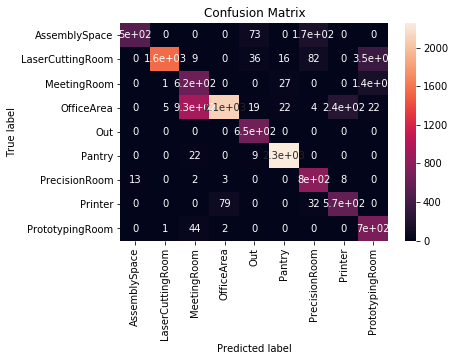

In [18]:
# Calculate training performance
plot_model_performance(Ytrain, train_labels, sorted(list(set(Ytrain))))

                  precision    recall  f1-score   support

   AssemblySpace       1.00      0.31      0.48       210
LaserCuttingRoom       0.97      0.59      0.73       898
     MeetingRoom       0.45      0.85      0.59       279
      OfficeArea       0.97      0.80      0.88      2124
             Out       0.97      1.00      0.98       153
          Pantry       0.98      0.97      0.97       777
   PrecisionRoom       0.59      0.98      0.74       263
         Printer       0.48      0.64      0.55       146
 PrototypingRoom       0.31      0.90      0.46       214

        accuracy                           0.79      5064
       macro avg       0.75      0.78      0.71      5064
    weighted avg       0.88      0.79      0.80      5064



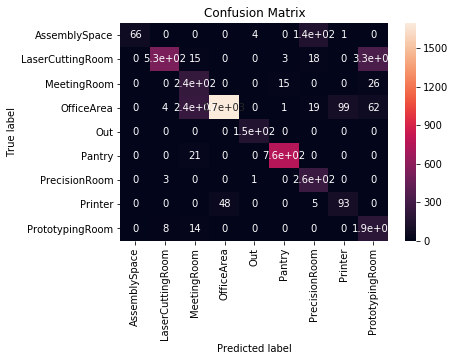

In [19]:
# Calculate test performance
plot_model_performance(Ytest, test_labels, sorted(list(set(Ytrain))))

# Visualise the training data and clustering results in 2D

In [20]:
def sort_legend(handles, labels):
    """
    This function rearranges the handles and labels of the legend based on alphabetical order.
    """
    temp = sorted(zip(handles, labels), key=operator.itemgetter(1))
    sorted_handles, sorted_labels = zip(*temp)
    sorted_handles, sorted_labels = list(sorted_handles), list(sorted_labels)
    
    if 'Model1' in sorted_labels:
        dropped_index = sorted_labels.index('Model1')
        del sorted_handles[dropped_index]
        del sorted_labels[dropped_index]
    elif 'Model2_Stage1' in sorted_labels:
        dropped_index = sorted_labels.index('Model2_Stage1')
        del sorted_handles[dropped_index]
        del sorted_labels[dropped_index]
    
    return sorted_handles, sorted_labels

In [21]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(Xtrain)

In [22]:
# palette dictionary for 12 classes
# palette = {'AssemblySpace':(0.9199999999999999, 0.3184, 0.28),
#            'LaserCuttingRoom':(0.9199999999999999, 0.6384, 0.28),
#            'MeetingRoom':(0.8815999999999997, 0.9199999999999999, 0.28),
#            'OfficeArea_1':(0.5616000000000001, 0.9199999999999999, 0.28),
#            'OfficeArea_2':(0.28, 0.9199999999999999, 0.31840000000000007),
#            'Out':(0.28, 0.9199999999999999, 0.6384),
#            'Pantry_FridgeCoffeeMachine':(0.28, 0.8815999999999997, 0.9199999999999999),
#            'Pantry_MicrowaveWaterDispenser':(0.28, 0.5616000000000001, 0.9199999999999999),
#            'Pantry_Other':(0.31840000000000007, 0.28, 0.9199999999999999),
#            'PrecisionRoom':(0.6383999999999997, 0.28, 0.9199999999999999),
#            'Printer':(0.9199999999999999, 0.28, 0.8815999999999997),
#            'PrototypingRoom':(0.9199999999999999, 0.28, 0.5616000000000001)}

In [23]:
# palette dictionary for 9 classes
palette = {'AssemblySpace':(0.9199999999999999, 0.3184, 0.28),
           'LaserCuttingRoom':(0.9199999999999999, 0.6384, 0.28),
           'MeetingRoom':(0.8815999999999997, 0.9199999999999999, 0.28),
           'OfficeArea':(0.5616000000000001, 0.9199999999999999, 0.28),
           'Out':(0.28, 0.9199999999999999, 0.6384),
           'Pantry':(0.28, 0.5616000000000001, 0.9199999999999999),
           'PrecisionRoom':(0.6383999999999997, 0.28, 0.9199999999999999),
           'Printer':(0.9199999999999999, 0.28, 0.8815999999999997),
           'PrototypingRoom':(0.9199999999999999, 0.28, 0.5616000000000001)}

In [24]:
renamed_labels = ['Assembly Space','Laser Cutting Room','Meeting Room',
                  'Office Area','Out','Pantry','Precision Room',
                  'Printer','Prototyping Room']

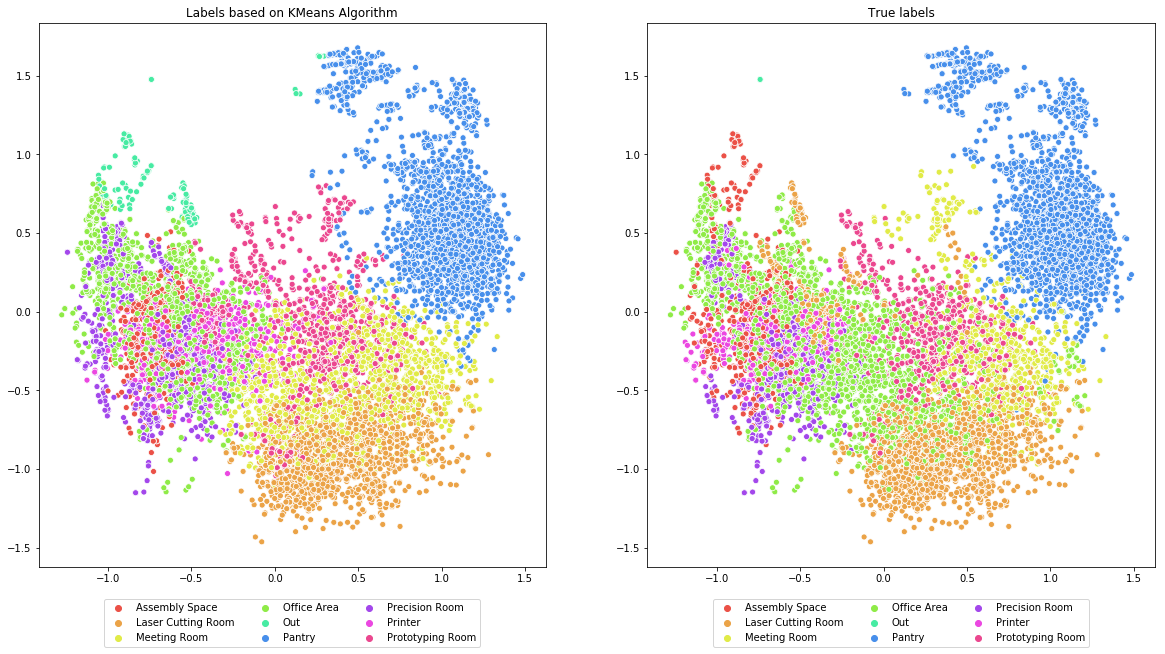

In [25]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,2,1)
fig1 = sns.scatterplot(train_pca[:,0], train_pca[:,1], hue=train_labels, palette=palette)
handles, labels = ax1.get_legend_handles_labels()
sorted_handles, sorted_labels = sort_legend(handles, labels)
ax1.legend(sorted_handles, renamed_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=3)
ax1 = plt.title('Labels based on KMeans Algorithm')

ax2 = plt.subplot(1,2,2)
fig2 = sns.scatterplot(train_pca[:,0], train_pca[:,1], hue=Ytrain, palette=palette)
handles, labels = ax2.get_legend_handles_labels()
sorted_handles, sorted_labels = sort_legend(handles, labels)
ax2.legend(sorted_handles, renamed_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
ax2 = plt.title('True labels')

# Visualise the test data and clustering results in 2D

In [26]:
test_pca = pca.transform(Xtest)

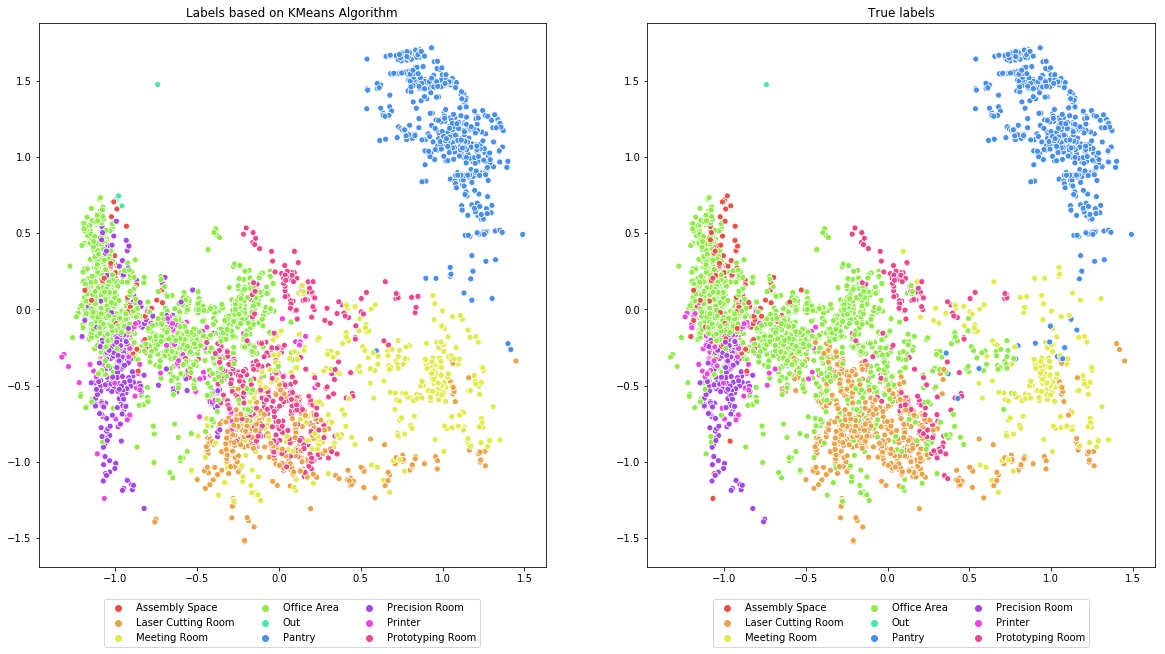

In [27]:
plt.figure(figsize=(20,10))
ax3 = plt.subplot(1,2,1)
fig3 = sns.scatterplot(test_pca[:,0], test_pca[:,1], hue=test_labels, palette=palette)
handles, labels = ax3.get_legend_handles_labels()
sorted_handles, sorted_labels = sort_legend(handles, labels)
ax3.legend(sorted_handles, renamed_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=3)
ax3 = plt.title('Labels based on KMeans Algorithm')

ax4 = plt.subplot(1,2,2)
fig4 = sns.scatterplot(test_pca[:,0], test_pca[:,1], hue=Ytest, palette=palette)
handles, labels = ax4.get_legend_handles_labels()
sorted_handles, sorted_labels = sort_legend(handles, labels)
ax4.legend(sorted_handles, renamed_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
ax4 = plt.title('True labels')

# Determine the optimal number of sample values to use when calculating the true centre

In [28]:
def determine_optimal_sample_value():
    """
    This function calculates the performance of the model when we choose different number of
    data points to calculate the true centres.
    """
    train_acc_list = []
    train_f1_list = []
    test_acc_list = []
    test_f1_list = []
    num_iter = 10
    num_samples_list = list(np.arange(5,101,5))
    
    train_data = pd.read_csv('movement_data/fingerprinting_data/train.csv')
    test_data = pd.read_csv('movement_data/fingerprinting_data/test.csv')
    Xtrain, Ytrain = prepare_data(train_data)
    Xtest, Ytest = prepare_data(test_data)

    # Define the number of classes
    zone_list = sorted(list(set(Ytrain)))
    num_classes = len(zone_list)

    for num_samples in num_samples_list:
        print('Number of samples: {}'.format(num_samples))
        train_acc = []
        train_f1 = []
        test_acc = []
        test_f1 = []
        for i in range(num_iter):
            # Sample "true" cluster centres from each zone
            true_centres = []
            true_centres_array = np.zeros((num_classes, Xtrain.shape[1]))
            for i in range(num_classes):
                centroid = calculate_true_centre(Xtrain[Ytrain == zone_list[i]], num_samples)
                true_centres.append((centroid, zone_list[i]))
                true_centres_array[i,:] = centroid
            
            # Clustering using kmeans algorithm
            kmeans = KMeans(n_clusters=num_classes, init=true_centres_array, n_jobs=-1)
            train_labels = kmeans.fit_predict(Xtrain)
            test_labels = kmeans.predict(Xtest)
            
            # Identify cluster centres based on kmeans algorithm
            cluster_centres = kmeans.cluster_centers_

            # Define a mapping between the labels from the clustering algorithm to the zones in the study area
            cluster_zone_mapping = map_cluster_to_zone(true_centres, cluster_centres, zone_list)
            zone_list = sorted(list(set(Ytrain)))

            # Relabel the cluster labels into zones in the study area
            train_labels = relabel_results(train_labels, cluster_zone_mapping)
            test_labels = relabel_results(test_labels, cluster_zone_mapping)

            # Calculate training performance
            train_cr = classification_report(train_labels, Ytrain, output_dict=True)
            train_acc.append(train_cr['accuracy'])
            train_f1.append(train_cr['macro avg']['f1-score'])
            
            # Calculate test performance
            test_cr = classification_report(test_labels, Ytest, output_dict=True)
            test_acc.append(test_cr['accuracy'])
            test_f1.append(test_cr['macro avg']['f1-score'])
            
        train_acc_list.append(train_acc)
        train_f1_list.append(train_f1)
        test_acc_list.append(test_acc)
        test_f1_list.append(test_f1)
        
    return train_acc_list, train_f1_list, test_acc_list, test_f1_list

In [29]:
train_acc_list, train_f1_list, test_acc_list, test_f1_list = determine_optimal_sample_value()

Number of samples: 5


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 10


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 15


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 20


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 25


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 30


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 35


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 40


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 45


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 50


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 55


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 60


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 65


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 70


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 75


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 80


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 85


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 90


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 95


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

Number of samples: 100


/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/Users/raymondlow/anaconda3/envs/ten

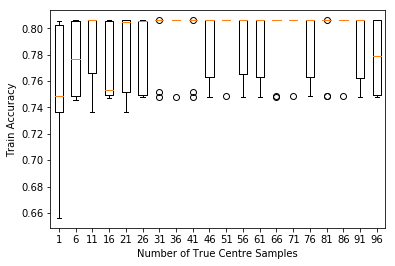

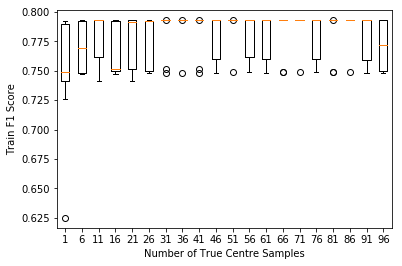

In [30]:
# Visualise training results
plt.boxplot(train_acc_list, labels=np.arange(1,101,5))
plt.ylabel('Train Accuracy')
plt.xlabel('Number of True Centre Samples')
plt.show()

plt.boxplot(train_f1_list, labels=np.arange(1,101,5))
plt.ylabel('Train F1 Score')
plt.xlabel('Number of True Centre Samples')
plt.show()

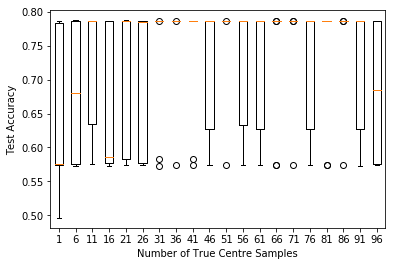

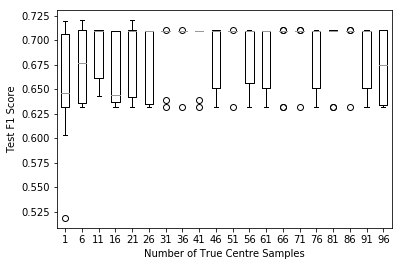

In [31]:
# Visualise test results
plt.boxplot(test_acc_list, labels=np.arange(1,101,5))
plt.ylabel('Test Accuracy')
plt.xlabel('Number of True Centre Samples')
plt.show()

plt.boxplot(test_f1_list, labels=np.arange(1,101,5))
plt.ylabel('Test F1 Score')
plt.xlabel('Number of True Centre Samples')
plt.show()